# "l1 Trend Filtering"
> "My reference notebook for l1 trend filtering."

- author: Christopher Thiemann
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [time series, lasso, trend-filtering]
- hide: false
- search_exclude: true
- image: images/l1_trend_filtering.png

In [94]:
#hide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
import cvxpy as cp
from scipy.sparse import dia_matrix
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error


## Motivation

When working with timeseries data $y_1, y_2,...y_t, ...y_T$ one decomposes the time series in different components most often that is trend, seasonal and a random component. $y_t = x_t + s_t + \varepsilon_t$. During my econmoics studies I first encountered the Hodrick -Prescott Filter (HP) in a macro course. As we will see, the HP filter produces a non linear trend component while the l1-trend filter will provide a piecewise linear trend component. This makes l2 trend filtgering more interpretable because we can interpret the kink points in the piece wiese linear solution as change points in the trends.

The corresponding paper is {% cite l1trendfilter %}

## Hodrick Prescott Filter

The Hp-Filter is defined as the solution to the following problem

$x^{HP} = argmin_{x \in R^T} 1 / 2 \sum_{t=1}^T (y_t-x_t)^2 + \lambda \sum_{t=2}^{T-1}(x_{t-1}-2x_t+x_{t+1})^2$

The second term penalized the roughness of the solution.

For $\lambda = 0$ we have $x_t^{HP} = y_t$ and for $\lambda -> \infty$ one can show that the solution is given by $x_t^{HP} = \alpha + \beta t$

An alternative formulation of the problem is

$1 / 2 ||y-x||_2^2 + \lambda ||Dx||_2^2$

where D is a $(T-2) \times T$ second order difference matrix. See below an example with $T = 10$

In [ ]:
#hide_input
calc_D(10)

array([[ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.]])

The solution can then be written as 

$x^{HP} = (I+2\lambda D' D)^{-1}y$

## l1 Trend Filtering

The problem is similar to the Hp Filter

$1 / 2 \sum_{t=1}^T (y_t-x_t)^2 + \lambda \sum_{t=2}^{T-1}|x_{t-1}-2x_t+x_{t+1}|$

it is possible to rewrite the problem as a lasso problem

$1 / 2 || A \theta - y||_2^2 + \lambda \sum_{t = 3}^T |\theta_t|$

Note that we are **not** penalizing the first two coeficients.

$A$ is a square T dimensional Matrix of the following form. (T = 10) 



In [ ]:
#hide_input
calc_A(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
       [1., 4., 3., 2., 1., 0., 0., 0., 0., 0.],
       [1., 5., 4., 3., 2., 1., 0., 0., 0., 0.],
       [1., 6., 5., 4., 3., 2., 1., 0., 0., 0.],
       [1., 7., 6., 5., 4., 3., 2., 1., 0., 0.],
       [1., 8., 7., 6., 5., 4., 3., 2., 1., 0.],
       [1., 9., 8., 7., 6., 5., 4., 3., 2., 1.]])

To recover the solution of the original l1 trend filtering problem we transform the solution as

$x = A \theta$

since the solution to the lasso problem is piecewiese linear the solution to the l1 trend filter is also piecewiese linear.

## Reproducing S&P 500 example

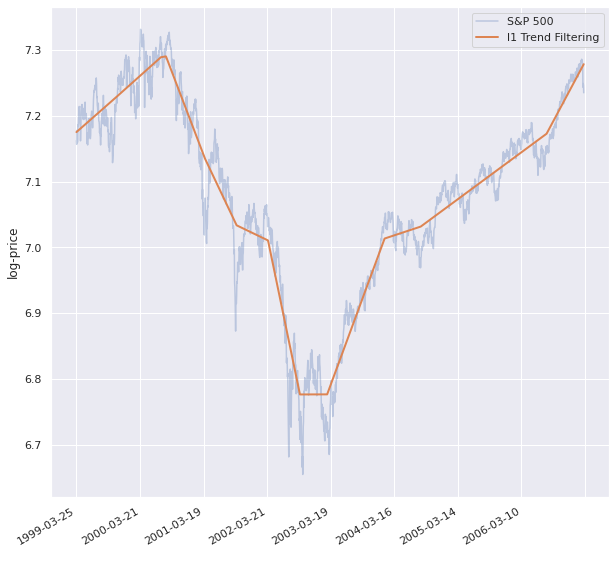

In [132]:
#data
# downloaded from https://finance.yahoo.com/quote/%5EGSPC/history?period1=922320000&period2=1172880000&interval=1d&filter=history&frequency=1d
ts = pd.read_csv("sandp.csv")
ts.rename( columns = {'Close': 'S&P 500'}, inplace = True)
log_price = np.log(ts['S&P 500'])
log_price.index = ts.Date

# apply trend filtering
solution_hp = HP_filter(log_price, 2000000)
solution_l1 = l1_trend_filter_lasso(log_price, 100)

#plotting
fig, axes = plt.subplots(figsize = (10, 10))

log_price.plot(ax = axes,alpha = .3)
fig.autofmt_xdate()

axes.plot(solution_l1, label = 'l1 Trend Filtering', linewidth = 2)
axes.set_ylabel("log-price")
axes.set_xlabel(" ")
axes.legend()
fig.savefig("l1_trend_filtering.png");

## Extension

It is possible to extend the trend filtering problem to respect seasonality, outliers or level shifts.

The problem is then

$1/2 ||y-x-u-w-\alpha sin(\omega t) -\beta cos(\omega t)||_2^2 + \lambda||Dx||_1+\rho||u||_1+\eta \sum_{t=2}^T|w_t-w_{t-1}|$

where $sin$ and $cos$ is understood vectorwise. $u$ models *spikes*, $w$ *level shifts* and $\alpha$ and $\beta$ measure the sinusoidal periodic component. $\omega$ is the frequency. $x$ is the trend component. For an implementation look in the helper functions section.

## Helper Functions

In [73]:
def calc_A(n):

    A = np.zeros((n, n))
    A[:, 0] = 1

    for i in range(1, n):

        A[i:, i] = list(range(1, n - i + 1))

    return A


def calc_D(n, return_sparse = False):

    D = np.zeros((n - 2, n))

    dif = np.array([1, -2, 1])

    for i in range(n-2):

        D[ i, i : (i+3)] = dif

    if return_sparse:

        return dia_matrix(D)
    else:
        return D

def HP_filter(ts, lam):

    n = len(ts)

    D = calc_D(n)

    return np.linalg.inv(np.eye(n) + 2 * lam * (D.T @ D)) @ ts

def l1_trend_filter_lasso(ts, lambda_value):

    n = len(ts)

    A = calc_A(n)

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)
    u = cp.Variable(n)
    lambd.value = lambda_value
    problem = cp.Problem(cp.Minimize(cp.norm2(A @ beta - ts)**2 + lambd * cp.norm1(beta[2 : ])))
    problem.solve(verbose = True, solver=cp.CVXOPT)


    solution = A @ beta.value

    return solution
    
def l1_trend_filter(ts, freq, lam, rho, eta):

    if isinstance(ts, pd.Series):

        ts = ts.to_numpy()





    n = len(ts)

    sin_comp = np.sin(freq * np.array(range(1, n + 1)))
    cosine_com = np.cos(freq * np.array(range(1, n + 1)))

    D = calc_D(n, return_sparse = True)

    #define variables
    a = cp.Variable(1)
    b = cp.Variable(1)
    w = cp.Variable(n)
    x = cp.Variable(shape=n)
    u = cp.Variable(shape = n)

    eta = eta
    rho = rho
    lam = lam

    obj = cp.Minimize(0.5 * cp.sum_squares( ts - x - a * sin_comp - b * cosine_com)
                                            + lam * cp.norm(D  @ x, 1)
                                            + rho * cp.norm(u, 1) 
                                            + eta * cp.norm(w[1:] - w[0:n-1],
                                            1) )
    prob = cp.Problem(obj)

    
    prob.solve(verbose=False)

    

    return x.value, u.value, w.value, a.value, b.value, mean_squared_error(ts, x.value + a.value * sin_comp + b.value * cosine_com)




{% bibliography --cited %}